In [1]:
import os
os.chdir('C:/Users/raffa/PycharmProjects/PortfolioProject')
import pandas as pd
from sqlalchemy import create_engine
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_exploration.data_exploration import *

In [2]:
df = read_sqlite_table('housedata', './data/processed/rome_house_explored.db')

In [3]:
df.shape

(15044, 55)

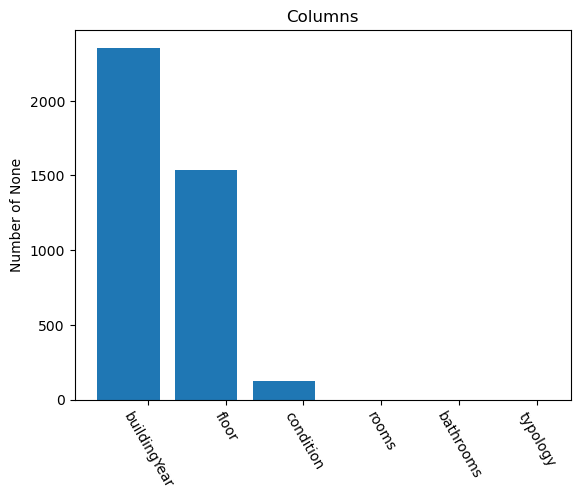

In [4]:
plot_bar(df.select_dtypes(include=[object]),missing_value='None')

In [5]:
class DataPreprocessor:
    
    def __init__(self, df):
        self.df = df
        
    def replace_with_nan(self,missing_values):
        self.df = self.df.replace(missing_values, np.nan)
        
        
    def train_test(self,train_size=0.8, seed=42):
        self.train = self.df.sample(frac=train_size, random_state=seed)
        self.test = self.df.drop(index=self.train.index)
    
    def plot_missing(self):
        
        cols_with_missing_train = pd.DataFrame()
        cols_with_missing_test = pd.DataFrame()

        for col in self.train.columns:
            if self.train[col].isna().sum()>0:    
                cols_with_missing_train[col] = self.train[col]

        for col in self.test.columns:
            if self.test[col].isna().sum()>0:    
                cols_with_missing_test[col] = self.test[col]
        if len(cols_with_missing_train)==0 and len(cols_with_missing_test)==0:
            print('No missing values')

        else:
            percentage_train = cols_with_missing_train.isna().sum()/len( cols_with_missing_train)
            percentage_train = percentage_train.sort_values(ascending=False)

            percentage_test = cols_with_missing_test.isna().sum()/len( cols_with_missing_test)
            percentage_test = percentage_test.sort_values(ascending=False)
            X = cols_with_missing_test.columns
            X_axis = np.arange(len(X))
            fig, ax = plt.subplots()  
            plt.bar(X_axis - 0.2, percentage_train, 0.4, label = 'Train')
            plt.bar(X_axis + 0.2, percentage_test, 0.4, label = 'Test')

            ax.set_xticks(X_axis, X, rotation = -45)
            ax.set_xlabel("Variables")
            ax.set_ylim([0, 1])
            ax.set_ylabel('% of Missing Values')
            ax.set_title('Missing Values')
            ax.legend()
            plt.show()

        plt.show()
    
    def replace_missing(self):

        for col in self.train_nomiss.columns:
            if self.train_nomiss[col].isna().sum()>0:
                
                if self.train[col].dtypes == 'object':
                    self.train_nomiss[col] = self.train_nomiss[col].replace(np.nan,self.train[col].mode()[0])
                    self.test_nomiss[col] = self.test_nomiss[col].replace(np.nan,self.train[col].mode()[0])
                    
                if is_numeric_dtype(self.train[col]):
                    self.train_nomiss[col] = self.train_nomiss[col].replace(np.nan,round(self.train[col].mean(),2))
                    self.test_nomiss[col] = self.test_nomiss[col].replace(np.nan,round(self.train[col].mean(),2))
                    
    def run_preprocessor(self,missing_values,train_size=0.8, seed=42):
        
        self.replace_with_nan(missing_values)
        self.split_train_test( train_size, seed)
        self.plot_missing()
        self.replace_missing()
        

In [6]:
from sklearn.preprocessing import OneHotEncoder

In [7]:
list(df.select_dtypes(include=[object]).columns)

['buildingYear', 'rooms', 'bathrooms', 'floor', 'typology', 'condition']

In [8]:
for col in df.select_dtypes(include=[object]).columns:
    df.loc[df[col] == 'None', col] = f'{col}Missing'

In [9]:
df['buildingYear'].value_counts()

1960-1969              4098
buildingYearMissing    2356
1970-1979              2053
1950-1959              1464
1980-1989              1000
2020-2029               810
2010-2019               535
1930-1939               493
Pre 1920                485
1990-1999               427
2000-2009               401
1900-1909               333
1940-1949               323
1920-1929               266
Name: buildingYear, dtype: int64

In [10]:
dpp = DataPreprocessor(df)

dpp.train_test(train_size=0.9, seed=42)

train = dpp.train 
test = dpp.test

In [11]:
train.shape, test.shape

((13540, 55), (1504, 55))

In [12]:
one_hot_cols = list(df.select_dtypes(include=[object]).columns)

for col in one_hot_cols:
    print(train[col].unique())

['buildingYearMissing' '1960-1969' '2010-2019' '1970-1979' '2000-2009'
 '1950-1959' '1930-1939' '1980-1989' '2020-2029' '1900-1909' '1940-1949'
 '1990-1999' 'Pre 1920' '1920-1929']
['3' '5' '2' '5+' '1' '4']
['1' '3' '2' '3+']
['floorMissing' '2' 'T' '5' '3' '1' '4' '6' '7' 'R' 'S' '8']
['Appartamento' 'Villetta a schiera' 'Attico - Mansarda' 'Villa' 'Loft'
 'Casa indipendente' 'Rustico - Casale']
['conditionMissing' 'Da ristrutturare' 'Ottimo / Ristrutturato'
 'Buono / Abitabile' 'Nuovo / In costruzione']


In [13]:
for col in one_hot_cols:
    ohe= OneHotEncoder(drop=None)
    train_ohe = ohe.fit_transform(train[[col]])
    test_ohe = ohe.transform(test[[col]])
    
    train[ohe.get_feature_names_out(input_features=None)] = train_ohe.toarray()
    test[ohe.get_feature_names_out(input_features=None)] = test_ohe.toarray()
    train = train.drop(ohe.get_feature_names_out(input_features=None)[-1], axis=1)
    test = test.drop(ohe.get_feature_names_out(input_features=None)[-1], axis=1)

In [14]:
train = train.select_dtypes(exclude=['object'])
test = test.select_dtypes(exclude=['object'])

In [15]:
train.shape, test.shape

((13540, 91), (1504, 91))

In [16]:
train.columns

Index(['latitude', 'longitude', 'price', 'surface', 'garage', 'isNew',
       'luxury', 'armadio a muro', 'arredato', 'balcone', 'caminetto',
       'cancello elettrico', 'cantina', 'cucina', 'esposizione doppia',
       'esposizione est', 'esposizione esterna', 'esposizione interna',
       'esposizione nord', 'esposizione ovest', 'esposizione sud',
       'fibra ottica', 'giardino comune', 'giardino privato',
       'giardino privato e comune', 'idromassaggio', 'impianto di allarme',
       'impianto tv centralizzato', 'impianto tv con parabola satellitare',
       'impianto tv singolo', 'infissi esterni in doppio vetro / legno',
       'infissi esterni in doppio vetro / metallo',
       'infissi esterni in doppio vetro / pvc',
       'infissi esterni in triplo vetro / legno',
       'infissi esterni in triplo vetro / metallo',
       'infissi esterni in triplo vetro / pvc',
       'infissi esterni in vetro / legno',
       'infissi esterni in vetro / metallo', 'infissi esterni in ve

In [17]:
train = train[['latitude', 'longitude', 'surface', 'garage', 'isNew',
       'luxury', 'armadio a muro', 'arredato', 'balcone', 'caminetto',
       'cancello elettrico', 'cantina', 'cucina', 'esposizione doppia',
       'esposizione est', 'esposizione esterna', 'esposizione interna',
       'esposizione nord', 'esposizione ovest', 'esposizione sud',
       'fibra ottica', 'giardino comune', 'giardino privato',
       'giardino privato e comune', 'idromassaggio', 'impianto di allarme',
       'impianto tv centralizzato', 'impianto tv con parabola satellitare',
       'impianto tv singolo', 'infissi esterni in doppio vetro / legno',
       'infissi esterni in doppio vetro / metallo',
       'infissi esterni in doppio vetro / pvc',
       'infissi esterni in triplo vetro / legno',
       'infissi esterni in triplo vetro / metallo',
       'infissi esterni in triplo vetro / pvc',
       'infissi esterni in vetro / legno',
       'infissi esterni in vetro / metallo', 'infissi esterni in vetro / pvc',
       'parzialmente arredato', 'piscina', 'porta blindata',
       'portiere intera giornata', 'portiere mezza giornata', 'reception',
       'solo cucina arredata', 'taverna', 'terrazza', 'videocitofono',
       'buildingYear_1900-1909', 'buildingYear_1920-1929',
       'buildingYear_1930-1939', 'buildingYear_1940-1949',
       'buildingYear_1950-1959', 'buildingYear_1960-1969',
       'buildingYear_1970-1979', 'buildingYear_1980-1989',
       'buildingYear_1990-1999', 'buildingYear_2000-2009',
       'buildingYear_2010-2019', 'buildingYear_2020-2029',
       'buildingYear_Pre 1920', 'rooms_1', 'rooms_2', 'rooms_3', 'rooms_4',
       'rooms_5', 'bathrooms_1', 'bathrooms_2', 'bathrooms_3', 'floor_1',
       'floor_2', 'floor_3', 'floor_4', 'floor_5', 'floor_6', 'floor_7',
       'floor_8', 'floor_R', 'floor_S', 'floor_T', 'typology_Appartamento',
       'typology_Attico - Mansarda', 'typology_Casa indipendente',
       'typology_Loft', 'typology_Rustico - Casale', 'typology_Villa',
       'condition_Buono / Abitabile', 'condition_Da ristrutturare',
       'condition_Nuovo / In costruzione', 'condition_Ottimo / Ristrutturato', 'price']]
test = test[['latitude', 'longitude', 'surface', 'garage', 'isNew',
       'luxury', 'armadio a muro', 'arredato', 'balcone', 'caminetto',
       'cancello elettrico', 'cantina', 'cucina', 'esposizione doppia',
       'esposizione est', 'esposizione esterna', 'esposizione interna',
       'esposizione nord', 'esposizione ovest', 'esposizione sud',
       'fibra ottica', 'giardino comune', 'giardino privato',
       'giardino privato e comune', 'idromassaggio', 'impianto di allarme',
       'impianto tv centralizzato', 'impianto tv con parabola satellitare',
       'impianto tv singolo', 'infissi esterni in doppio vetro / legno',
       'infissi esterni in doppio vetro / metallo',
       'infissi esterni in doppio vetro / pvc',
       'infissi esterni in triplo vetro / legno',
       'infissi esterni in triplo vetro / metallo',
       'infissi esterni in triplo vetro / pvc',
       'infissi esterni in vetro / legno',
       'infissi esterni in vetro / metallo', 'infissi esterni in vetro / pvc',
       'parzialmente arredato', 'piscina', 'porta blindata',
       'portiere intera giornata', 'portiere mezza giornata', 'reception',
       'solo cucina arredata', 'taverna', 'terrazza', 'videocitofono',
       'buildingYear_1900-1909', 'buildingYear_1920-1929',
       'buildingYear_1930-1939', 'buildingYear_1940-1949',
       'buildingYear_1950-1959', 'buildingYear_1960-1969',
       'buildingYear_1970-1979', 'buildingYear_1980-1989',
       'buildingYear_1990-1999', 'buildingYear_2000-2009',
       'buildingYear_2010-2019', 'buildingYear_2020-2029',
       'buildingYear_Pre 1920', 'rooms_1', 'rooms_2', 'rooms_3', 'rooms_4',
       'rooms_5', 'bathrooms_1', 'bathrooms_2', 'bathrooms_3', 'floor_1',
       'floor_2', 'floor_3', 'floor_4', 'floor_5', 'floor_6', 'floor_7',
       'floor_8', 'floor_R', 'floor_S', 'floor_T', 'typology_Appartamento',
       'typology_Attico - Mansarda', 'typology_Casa indipendente',
       'typology_Loft', 'typology_Rustico - Casale', 'typology_Villa',
       'condition_Buono / Abitabile', 'condition_Da ristrutturare',
       'condition_Nuovo / In costruzione', 'condition_Ottimo / Ristrutturato', 'price']]

<Axes: >

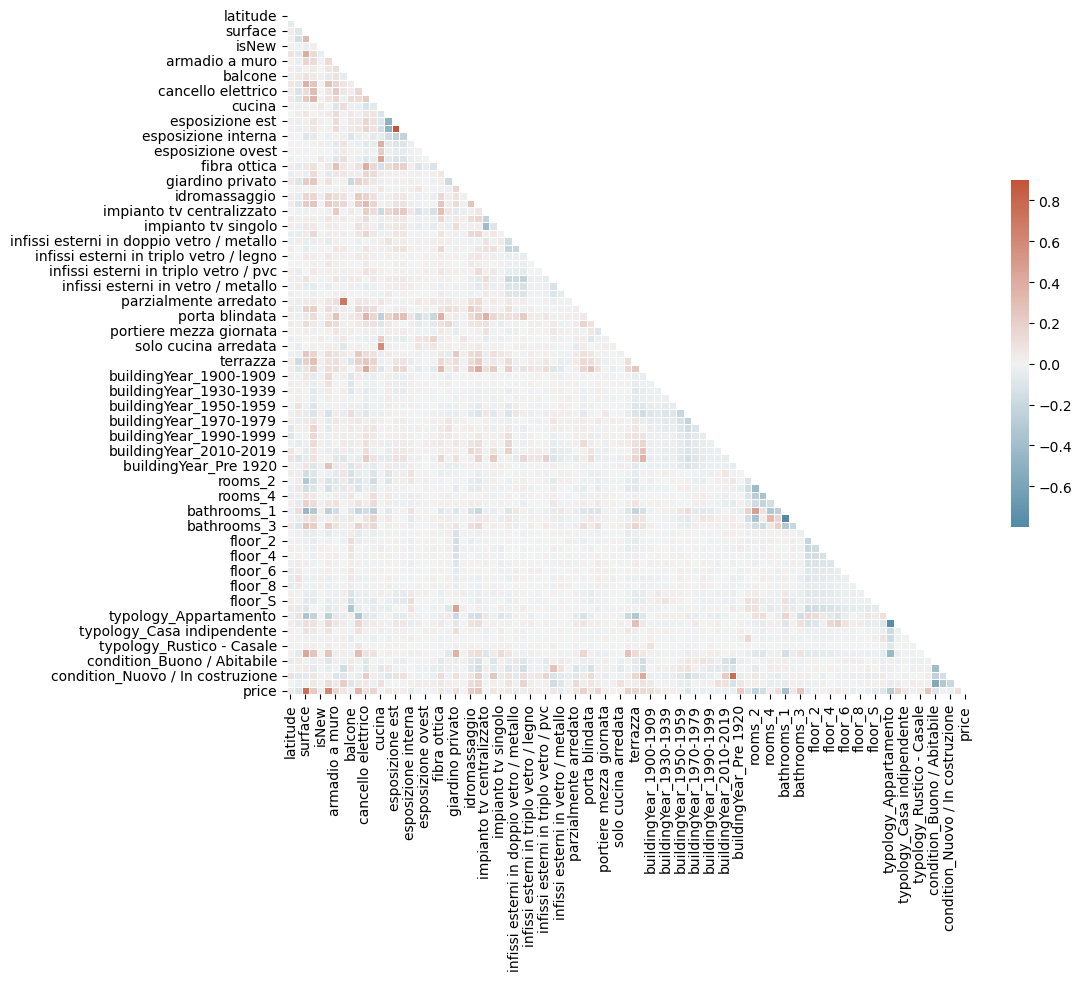

In [18]:
# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [19]:
train.shape, test.shape

((13540, 91), (1504, 91))

In [20]:
save_to_sql('./data/train_test/train_data_lgb.db', train, 'train')
save_to_sql('./data/train_test/test_data_lgb.db', test, 'test')